# KNeighborsClassifier 타이타닉 생존자 예측 및 성능평가

*   타이타닉 생존자(1), 사망자(0) 예측하는 이진분류 모델로 정의

In [ ]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 11.3 MB/s eta 0:00:00


## 데이터 준비하기

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


## 데이터 탐색 및 데이터 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### *NaN 값이 많은 컬럼 삭제

In [ ]:
# deck(객실 데크 위치), embark_town(승선도시) 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)
rdf

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,yes,True


In [ ]:
# age컬럼에 나이가 없는 NaN 데이터 확인 -> 177건만 삭제 -> 714건
rdf['age'].isna().sum()

177

In [ ]:
rdf = rdf.dropna(subset=['age'], how='any', axis=0)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    712 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


### 학습에 필요한 특성(feature) 추출

In [ ]:
# survived(생존여부), pclass(객실등급), sex(성별), age(나이), sibsp(같이 탑승한 형제/자매수), parch(부모/자녀수)
rdf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch']]
rdf.head()

,survived,pclass,sex,age,sibsp,parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [ ]:
rdf

,survived,pclass,sex,age,sibsp,parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0
...,...,...,...,...,...,...
885,0,3,female,39.0,0,5
886,0,2,male,27.0,0,0
887,1,1,female,19.0,0,0
889,1,1,male,26.0,0,0


### 성별 컬럼의 값을 범주형(모델이 인식할 수 있는)으로 전처리

In [ ]:
# 남성->0, 여성->1
# 모델이 학습할 때 도움이 될 수 있는 형태로 전처리 -> 원핫인코딩
# 남성->[1,0], 여성->[0,1]

onehat_sex = pd.get_dummies(rdf['sex']) # 컬럼 형태로 제공
onehat_sex

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
885,1,0
886,0,1
887,1,0
889,0,1


In [ ]:
# 기존 컬럼에 붙이기
ndf = pd.concat([rdf, onehat_sex], axis=1)
ndf.head()

,survived,pclass,sex,age,sibsp,parch,female,male
0,0,3,male,22.0,1,0,0,1
1,1,1,female,38.0,1,0,1,0
2,1,3,female,26.0,0,0,1,0
3,1,1,female,35.0,1,0,1,0
4,0,3,male,35.0,0,0,0,1


### 필요없는 기존 컬럼 삭제

In [ ]:
ndf.drop(['sex'], axis=1, inplace=True)
ndf.head()

,survived,pclass,age,sibsp,parch,female,male
0,0,3,22.0,1,0,0,1
1,1,1,38.0,1,0,1,0
2,1,3,26.0,0,0,1,0
3,1,1,35.0,1,0,1,0
4,0,3,35.0,0,0,0,1


## 데이터셋 분리하기

### 데이터(fearture)와 타깃(target) 분리

In [ ]:
X = ndf[['pclass',	'age',	'sibsp',	'parch',	'female',	'male']]
y = ndf['survived']
X.shape

(714, 6)

### 성능 평가를 위한 trainset, testset 분리(70:30)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7) # 70:30

In [ ]:
X_train.shape

(499, 6)

In [ ]:
X_test.shape

(215, 6)

## 이웃의 수(1~10)에 따른 성능 평가

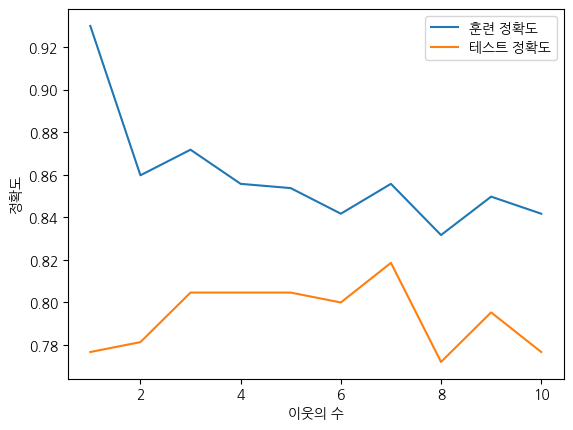

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 이웃의 수에 따른 정확도를 저장할 리스트 변수
train_scores = []
test_scores = []

# 이웃의 수 변수
n_neighbors_settings = range(1,11)

# 1~10까지 n_neighbors의 수를 증가시켜 학습 후 정확도 저장
for n_neighbors in n_neighbors_settings:
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(X_train, y_train)

  # 훈련데이터셋 정확도 저장
  train_scores.append(knn.score(X_train, y_train))

  # 테스트데이터셋 정확도 저장
  test_scores.append(knn.score(X_test, y_test))

# 예측 정확도 비교 그래프 그리기

plt.figure(dpi=100)

plt.plot(n_neighbors_settings, train_scores, label='훈련 정확도')
plt.plot(n_neighbors_settings, test_scores, label='테스트 정확도')
plt.xlabel('이웃의 수')
plt.ylabel('정확도')
plt.legend()
plt.show()


## 타이타닉 생존자 예측 모델 성능 평가

In [ ]:
# 최적점의 이웃으로 모델 객체 생성
knn = KNeighborsClassifier(n_neighbors=7)

# 모델 학습
knn.fit(X_train,y_train)

# 예측하기
y_pred = knn.predict(X_test)

### 분류레포트 활용

In [ ]:
knn.score(X_test, y_test)

0.8186046511627907

In [ ]:
from sklearn import metrics

knn_report = metrics.classification_report(y_test, y_pred)
print(knn_report)

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       126
           1       0.82      0.72      0.77        89

    accuracy                           0.82       215
   macro avg       0.82      0.80      0.81       215
weighted avg       0.82      0.82      0.82       215



### 성능 평가지표 계산 활용

In [ ]:
print('테스트 성능평가 n_neighbors=7')
print('accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('precision: ', metrics.precision_score(y_test, y_pred))
print('recall: ', metrics.recall_score(y_test, y_pred))
print('f1: ', metrics.f1_score(y_test, y_pred))

테스트 성능평가 n_neighbors=7
accuracy:  0.8186046511627907
precision:  0.8205128205128205
recall:  0.7191011235955056
f1:  0.7664670658682635
